# Evolving the Robot Controller

In [1]:
from random import randint, random, sample
import numpy as np
import seaborn as sns
from Problem_Domain.environment import Environment
from Robots.lookup_table_robot import LookupTableRobot

In [2]:
robot = LookupTableRobot()
environment = Environment()

In [3]:
LOOKUP_TABLE_SIZE = 243
NUMBER_OF_TRIALS_PER_EVALUATION = 10
NUMBER_OF_ACTIONS_PER_TRIAL = 200
POPULATION_SIZE = 200
NUMBER_OF_ELITES = 1
NUMBER_OF_GENERATIONS = 500
TOURNAMENT_SIZE = 4
EXPECTED_NO_OF_MUTATIONS_PER_CHILD = 2
MUTATION_RATE = EXPECTED_NO_OF_MUTATIONS_PER_CHILD/LOOKUP_TABLE_SIZE

In [4]:
def random_individual():
    """
    Generates a random sequence of integers between 0 and 6.
    One integer for each action in the lookup table.
    """
    individual = np.random.randint(0, 7, LOOKUP_TABLE_SIZE)
    return individual

In [5]:
def select_parent(fitnesses):
    """
    Uses tournament selection to select a parent from the population.
    """
    candidates = sample(range(len(fitnesses)), TOURNAMENT_SIZE)
    candidate_fitnesses = [fitnesses[i] for i in candidates]
    selected_parent = candidates[candidate_fitnesses.index(
        max(candidate_fitnesses))]
    return selected_parent

In [6]:
def crossover(parent1, parent2, child1, child2):
    """
    Performs single-point crossover between two parents to create two children.
    """
    crossover_point = randint(0, len(parent1) - 1)
    #child1 = np.empty(LOOKUP_TABLE_SIZE, dtype=int)
    #child2 = np.empty(LOOKUP_TABLE_SIZE, dtype=int)
    child1[:crossover_point] = parent1[:crossover_point]
    child1[crossover_point:] = parent2[crossover_point:]
    child2[:crossover_point] = parent2[:crossover_point]
    child2[crossover_point:] = parent1[crossover_point:]

    #return child1, child2

In [7]:
def mutate(lookup_table):
    """
    Mutates the lookup table by randomly changing a small number genes.
    """
    for i in range(len(lookup_table)):
        if random() < MUTATION_RATE:
            lookup_table[i] = np.random.randint(0, 7)

In [8]:
def evaluate(lookup_table, seeds):
    """
    Evaluates the robot behaviour by running it in the environment.
    """
    robot.set_lookup_table(lookup_table)
    robot.score = 0
    total_score = 0
    for i in range(NUMBER_OF_TRIALS_PER_EVALUATION):
        environment.randomise(random_seed=seeds[i])
        robot.set_environment(environment)
        environment.set_robot(robot)
        for _ in range(NUMBER_OF_ACTIONS_PER_TRIAL):
            action = robot.choose_action()
            environment.perform_action(action)
            if environment.number_of_cans == 0:
                break
        total_score += robot.score
    return total_score / NUMBER_OF_TRIALS_PER_EVALUATION

In [9]:
def get_next_generation(population, current, next, fitnesses, best_from_previous_generation):
    """
    Generates the next generation of the population using,
    selection, crossover, and mutation.
    """
    i = 0
    population[i][next] = best_from_previous_generation
    while i < POPULATION_SIZE:
        parent1 = population[select_parent(fitnesses)][current]
        parent2 = population[select_parent(fitnesses)][current]
#        child1, child2 = crossover(parent1, parent2)
        child1 = population[i + 1][next]
        child2 = population[i + 2][next]
        crossover(parent1, parent2, child1, child2)
        mutate(child1)
        mutate(child2)
        #population[i + 1][next] = child1
        #population[i + 2][next] = child2
        i += 2

## Generate the initial random population

First create an uninitialised 3D array. The dimensions are:
- Total individuals in the population
- Current/next generation (size 2)
- Size of lookup table

In [10]:
population = np.empty((POPULATION_SIZE + NUMBER_OF_ELITES,
                       2,
                       LOOKUP_TABLE_SIZE), dtype=int)

current, next = 0, 1

Initialise the current population to a collection of randomly generated individuals.

In [11]:
for i in range(POPULATION_SIZE + NUMBER_OF_ELITES):
    population[i][current] = random_individual()

Create an empty array to store the fitness scores.

In [12]:
fitness_scores = np.empty(POPULATION_SIZE + NUMBER_OF_ELITES, dtype=float)

Create a set of random seeds. This ensures that all individuals will be evaluated on the same set of randomly generated environments. The seeds will be changed every generation to avoid overfitting on a particular set of environments.

In [13]:
def get_random_seeds():
    return [randint(-2147483648, 2147483647)
            for _ in range(NUMBER_OF_TRIALS_PER_EVALUATION)]

Calculate the fitness scores for each member of the population.

In [14]:
for i in range(POPULATION_SIZE + NUMBER_OF_ELITES):
    fitness_scores[i] = evaluate(population[i][current], get_random_seeds())

Create lists to store the best and mean fitness for each generation. We'll graph these values later.

In [15]:
best_fitnesses = []
mean_fitnesses = []

Record the best and mean fitness of the initial population.

In [16]:
def update_stats():
    best_fitnesses.append(fitness_scores.max())
    mean_fitnesses.append(fitness_scores.mean())

In [17]:
update_stats()

In [18]:
print(f'Best fitness in initial population: {best_fitnesses[-1]}')

Best fitness in initial population: 1.5


Find the best individual in the initial population.

In [19]:
best_lookup_table = population[np.argmax(fitness_scores)][current]

## Evolve the Simulated Robot Controller

Successively breed new generations of robot controllers.

In [20]:
for generation in range(1, NUMBER_OF_GENERATIONS + 1):
    print(
        f'Generation {generation} of {NUMBER_OF_GENERATIONS}, best so far: {best_fitnesses[-1]}...',
        end="\r")
    
    get_next_generation(
        population,
        current,
        next,
        fitness_scores,
        best_lookup_table)
    
    # Toggle the current and next generations
    current, next = next, current

    # The fitness score for the same individual could change because the evaluation
    # is being carried out on a different set of randomly generated environments.
    random_seeds = get_random_seeds()
    for i in range(POPULATION_SIZE):
       fitness_scores[i] = evaluate(population[i][current], random_seeds)

    update_stats()
    best_lookup_table = population[np.argmax(fitness_scores)][current]

## Plot the Maximum and Mean Fitness for Each Generation

<Axes: >

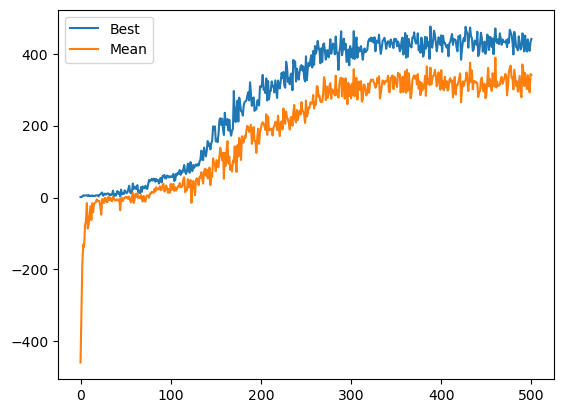

In [21]:
sns.lineplot(
    x=range(NUMBER_OF_GENERATIONS + 1),
    y=best_fitnesses, label='Best')
sns.lineplot(
    x=range(NUMBER_OF_GENERATIONS + 1),
    y=mean_fitnesses, label='Mean')

## Show the Best Solution Found
This can be copied and pasted as the default lookup tabe in LookupTableRobot. 

In [22]:
print(f'\nBest fitness: {best_fitnesses[-1]}')
print(list(best_lookup_table))


Best fitness: 441.5
[5, 1, 4, 3, 3, 6, 4, 1, 4, 0, 0, 0, 0, 1, 5, 0, 0, 0, 6, 6, 1, 0, 0, 5, 6, 5, 3, 4, 4, 4, 3, 2, 6, 1, 2, 4, 0, 0, 0, 4, 1, 6, 5, 4, 0, 1, 4, 1, 5, 2, 4, 5, 1, 0, 3, 1, 2, 3, 1, 6, 1, 6, 2, 0, 0, 0, 0, 0, 0, 0, 5, 5, 6, 5, 3, 5, 2, 0, 1, 2, 4, 2, 2, 5, 2, 2, 1, 4, 4, 4, 0, 1, 0, 0, 1, 4, 0, 0, 0, 4, 6, 3, 5, 0, 0, 1, 5, 1, 4, 3, 4, 1, 2, 0, 4, 5, 4, 4, 4, 0, 4, 4, 6, 4, 4, 0, 0, 5, 0, 4, 5, 0, 1, 1, 0, 2, 3, 2, 3, 0, 3, 4, 4, 4, 0, 0, 0, 0, 1, 2, 3, 2, 6, 1, 0, 3, 0, 2, 0, 2, 2, 0, 1, 1, 3, 1, 3, 4, 4, 3, 0, 0, 0, 5, 0, 4, 4, 6, 3, 2, 6, 4, 2, 1, 1, 1, 4, 4, 5, 4, 3, 3, 5, 3, 2, 4, 0, 5, 0, 5, 6, 0, 6, 0, 1, 0, 3, 3, 6, 6, 5, 4, 1, 0, 2, 4, 1, 1, 5, 3, 3, 5, 4, 2, 0, 0, 1, 1, 4, 0, 3, 1, 1, 0, 2, 5, 2, 0, 5, 6, 5, 2, 3]
